In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, IterableDataset
import torchvision
from torchvision import datasets, models, transforms
import transformers
import sklearn
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = ['SimHei', 'Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import json, copy, re, random, time, datetime
from tqdm.notebook import tqdm
%matplotlib inline

# EDA

In [3]:
train_data = pd.read_csv('Final Project/data/mgis489_train.csv')
test_data_temp = pd.read_csv('Final Project/data/mgis489_test.csv')
test_data = test_data_temp.iloc[:, 1:]
transactionID = test_data_temp.iloc[:, 0]
train_data.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,1728.0,39.45,2.0,9.0,497,0.015625,0.022830,0.074074,0
1,2,340.0,25.97,4.0,3.0,878,0.073529,0.076382,0.160000,0
2,5,216.0,57.92,9.0,5.0,343,0.046296,0.268148,0.900000,0
3,2,768.0,85.96,11.0,6.0,343,0.002604,0.111927,5.500000,0
4,4,694.0,92.44,7.0,5.0,1,0.005764,0.133199,1.750000,0


In [4]:
train_data.dropna(inplace=True)

In [5]:
train_data.shape, test_data.shape

((316047, 10), (135836, 9))

Text(0, 0.5, 'Count')

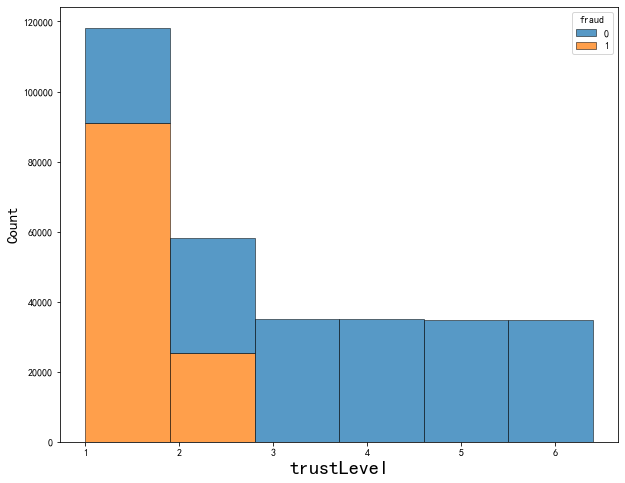

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.histplot(data=train_data, x='trustLevel', hue='fraud', multiple="stack",linewidth=.5,bins=6, binwidth=.9)
plt.xlabel('trustLevel', fontsize=20)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'totalScanTimeInSeconds')

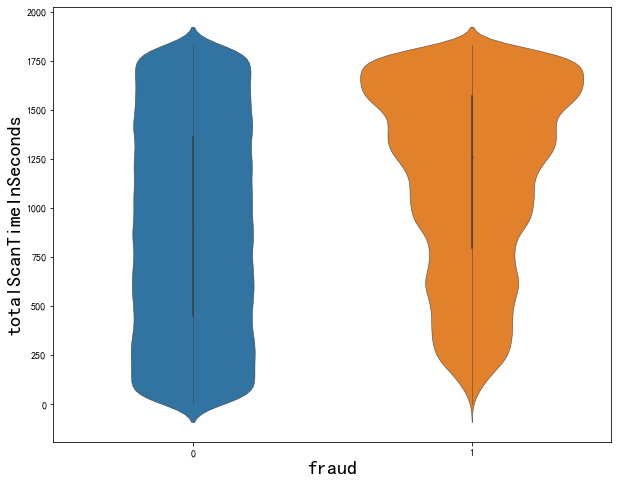

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.violinplot(data=train_data, x='fraud',y="totalScanTimeInSeconds",linewidth=.5,bins=6, binwidth=.9)
plt.xlabel('fraud', fontsize=20)
plt.ylabel("totalScanTimeInSeconds", fontsize=20)

Text(0.410555555555554, 0.5, 'Density')

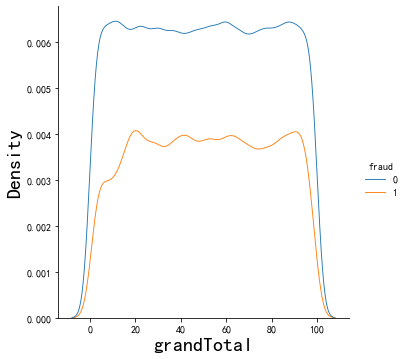

In [8]:
sns.displot(data=train_data, x='grandTotal',hue='fraud',kind='kde',linewidth=.9)
plt.xlabel('grandTotal', fontsize=20)
plt.ylabel("Density", fontsize=20)

* trustLevel  客户的个人信任级别。 6：最高可信度  {1,2,3,4,5,6}
* totalScanTimeInSeconds  第一个和最后一个扫描产品之间的总时间（以秒为单位）   正整数
* grandTotal 扫描的产品总数  最多两位小数的正十进制数
* lineItemVoids 无效扫描次数  正整数
* scansWithoutRegistration 尝试激活扫描仪而不实际扫描任何内容的次数  0或者正整数
* quantityModification  已扫描产品之一的修改数量 0或者正整数
* scannedLineItemsPerSecond 平均每秒扫描产品数  正浮点数
* valuePerSecond 每秒扫描产品的平均总值  正浮点数
* lineItemVoidsPerPosition 所有已扫描且未取消的产品总数中的平均项目无效数  正浮点数
* fraud 分类为欺诈 (1) 或非欺诈 (0) {0,1}

In [9]:
train_data.fraud.value_counts()

0    199507
1    116540
Name: fraud, dtype: int64

Text(0, 0.5, 'fraud')

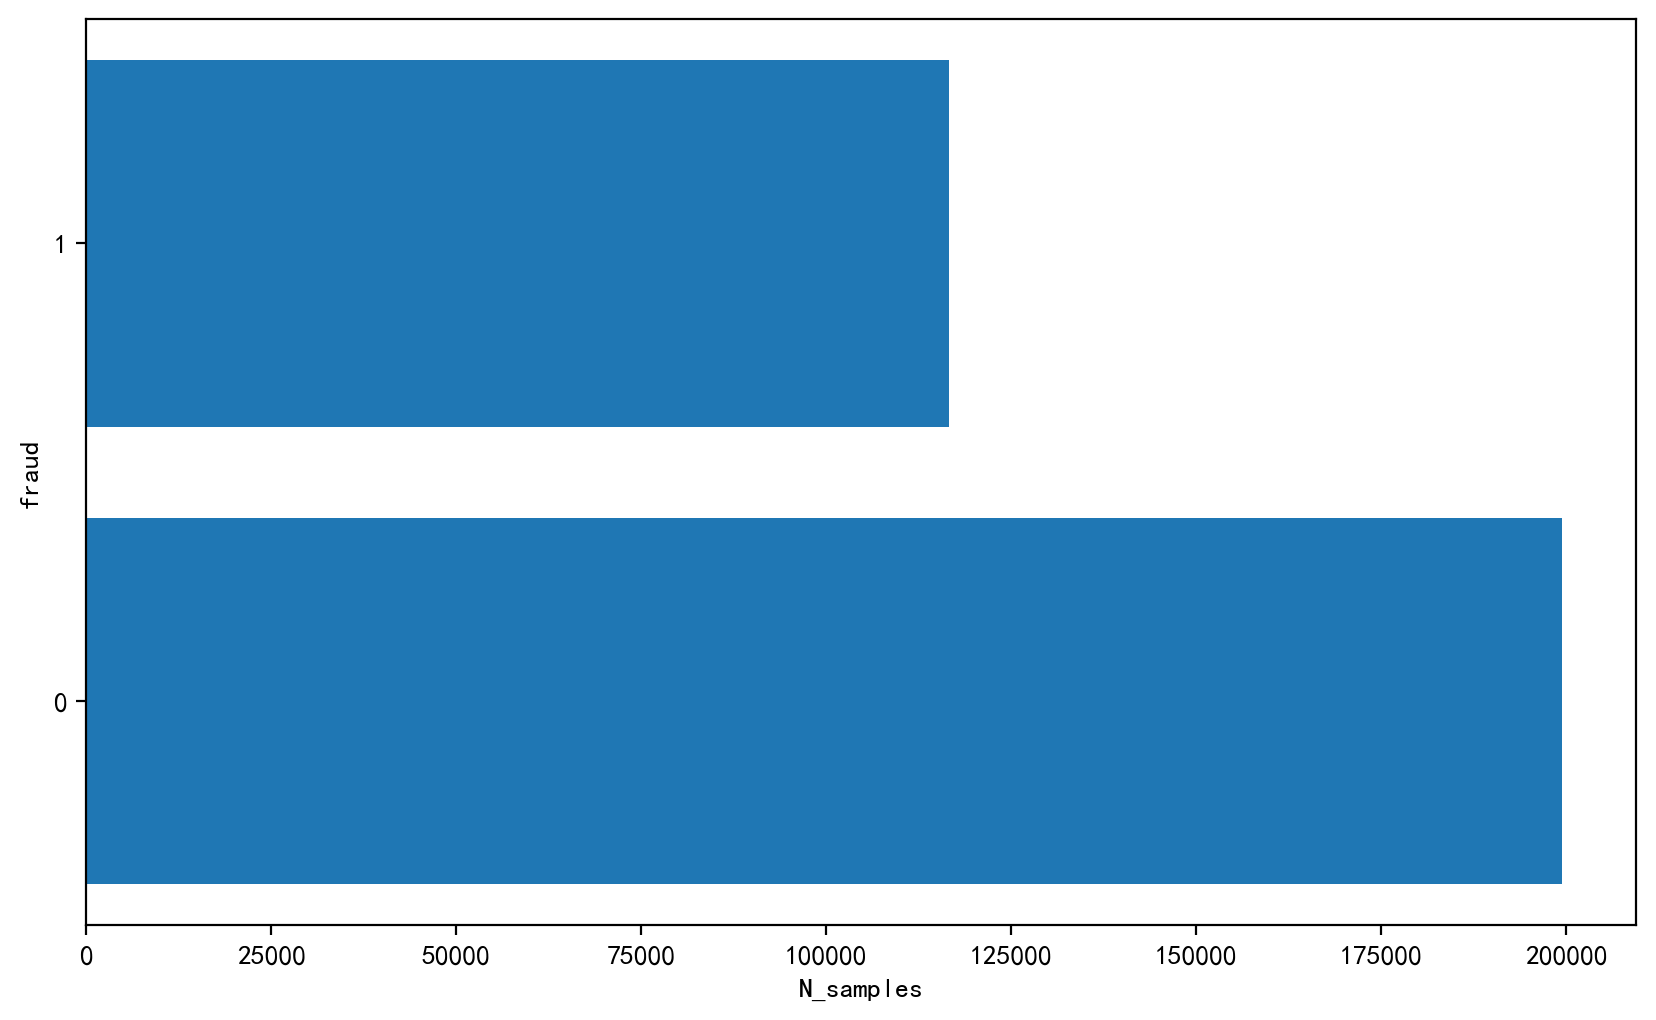

In [10]:
plt.figure(figsize=(10, 6), dpi=200)
plt.barh(y=[0,1], width=[199486, 116538])
plt.yticks([0, 1])
plt.xlabel('N_samples')
plt.ylabel('fraud')

# Polynomial Features

In [11]:
train_data.shape

(316047, 10)

In [12]:
# Interaction
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(include_bias=False, interaction_only=True).fit(train_data.iloc[:, :-1])

In [13]:
pd.DataFrame(pf.transform(train_data.iloc[:, :-1])).shape

(316047, 45)

In [14]:
train_data.iloc[:, -1].shape

(316047,)

In [15]:
data_poly = pd.DataFrame(pf.transform(train_data.iloc[:, :-1]), columns = pf.get_feature_names_out())
data_poly['fraud'] = train_data.iloc[:, -1].values

In [16]:
poly2 = pd.read_csv('data_poly.csv')

In [17]:
data_poly.shape

(316047, 46)

In [18]:
poly2.shape

(316024, 46)

# Models
* Random forest
* multiple perceptron
* XGBoost

In [189]:
data_poly.shape

(316024, 46)

In [24]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict, cross_validate

In [25]:
rfc_prediction = cross_val_predict(RandomForestClassifier(n_jobs=-1), data_poly.iloc[:, :-1], data_poly.iloc[:, -1], cv=5, verbose=True)
print(accuracy_score(rfc_prediction, data_poly.iloc[:, -1]))
rfc_cm = confusion_matrix(rfc_prediction, data_poly.iloc[:, -1])
rfc_cm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9964688796286628


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


array([[198763,    372],
       [   744, 116168]], dtype=int64)

In [26]:
mlp_prediction = cross_val_predict(MLPClassifier(), data_poly.iloc[:, :-1], data_poly.iloc[:, -1], cv=5,n_jobs=-1, verbose=True)
print(accuracy_score(mlp_prediction, data_poly.iloc[:, -1]))
mlp_cm = confusion_matrix(mlp_prediction, data_poly.iloc[:, -1])
mlp_cm

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


0.9719313899514945


array([[191893,   1257],
       [  7614, 115283]], dtype=int64)

In [27]:
xgb_prediction = cross_val_predict(XGBClassifier(n_jobs=-1), data_poly.iloc[:, :-1], data_poly.iloc[:, -1], cv=5, verbose=True)
print(accuracy_score(xgb_prediction, data_poly.iloc[:, -1]))
xgb_cm = confusion_matrix(xgb_prediction, data_poly.iloc[:, -1])
xgb_cm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.978632924849785


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


array([[199269,   6515],
       [   238, 110025]], dtype=int64)

### XGBoost parameter optimization

In [15]:
from xgboost import XGBClassifier
import numpy as np
import hyperopt
estimators=np.array([*range(50, 300)])
lr = np.linspace(0.001, 0.2, 20)
subsamples = np.linspace(0.1, 1, 20)
gammas = np.arange(0, 10, 0.1)
max_depths = np.arange(5, 25)
max_leaveses = np.arange(2, 1000, 5)
colsample_bytrees = np.linspace(0.1, 1, 20)
colsample_bylevels = np.linspace(0.1, 1, 20)

hyperopt_params = {
    'n_estimators': hyperopt.hp.choice('n_estimators', estimators),
    'learning_rate': hyperopt.hp.choice('learning_rate', lr),
    'subsample': hyperopt.hp.choice('subsample', subsamples),
    'gamma': hyperopt.hp.choice('gamma', gammas),
    'max_depth': hyperopt.hp.choice('max_depth', max_depths),
    'max_leaves': hyperopt.hp.choice('max_leaves', max_leaveses),
    'colsample_bytree': hyperopt.hp.choice('colsample_bytree', colsample_bytrees),
    'colsample_bylevel': hyperopt.hp.choice('colsample_bylevel', colsample_bylevels),
}

In [19]:
import hyperopt
from sklearn.model_selection import KFold, cross_val_score
def hyperopt_objective(params):  
    n_estimators = params['n_estimators']
    learning_rate = params['learning_rate']
    subsample = params['subsample']
    gamma = params['gamma']
    max_leaves = params['max_leaves']
    max_depth = params['max_depth']
    colsample_bytree = params['colsample_bytree']
    colsample_bylevel = params['colsample_bylevel']
    xgbc = XGBClassifier(
        scale_pos_weight=1.71, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, gamma=gamma,  max_depth=max_depth,max_leaves=max_leaves, colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, random_state=1, silent=True
    )
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(xgbc, sample_data_poly.iloc[:, :-1], sample_data_poly.iloc[:, -1], cv=cv, n_jobs=-1, error_score='raise')
    return -np.mean(score)

In [20]:
from hyperopt.early_stop import no_progress_loss
def hyperopt_optimize(n_trials=100):
    trial = hyperopt.Trials()  # saving process
    early_stop_fn = no_progress_loss(30) # 当目标函数连续30次没有变化时就提前停止
    param_best = hyperopt.fmin(
        hyperopt_objective,
        space=hyperopt_params,
        algo=hyperopt.tpe.suggest,
        # algo = algo  # 设置自定义代理模型
        max_evals=n_trials,
        verbose=True,
        trials=trial,
        early_stop_fn=early_stop_fn,
    )
    print(f"最优参数：{param_best}")
    return trial, param_best

In [21]:
hyperopt_optimize(200)

 50%|██████████████████████▌                      | 100/200 [21:18<21:18, 12.78s/trial, best loss: -0.9948749999999998]
最优参数：{'colsample_bylevel': 13, 'colsample_bytree': 17, 'gamma': 21, 'learning_rate': 11, 'max_depth': 17, 'max_leaves': 150, 'n_estimators': 195, 'subsample': 8}


(<hyperopt.base.Trials at 0x1f4e1087eb0>,
 {'colsample_bylevel': 13,
  'colsample_bytree': 17,
  'gamma': 21,
  'learning_rate': 11,
  'max_depth': 17,
  'max_leaves': 150,
  'n_estimators': 195,
  'subsample': 8})

In [23]:
estimators=np.array([*range(50, 300)])
lr = np.linspace(0.001, 0.2, 20)
subsamples = np.linspace(0.1, 1, 20)
gammas = np.arange(0, 10, 0.1)
max_depths = np.arange(5, 25)
max_leaveses = np.arange(2, 1000, 5)
colsample_bytrees = np.linspace(0.1, 1, 20)
colsample_bylevels = np.linspace(0.1, 1, 20)


best_param = {'colsample_bylevel': colsample_bylevels[13], 
              'colsample_bytree': colsample_bytrees[17], 
              'gamma': gammas[21], 
              'learning_rate': lr[11], 
              'max_depth': max_depths[17], 
              'max_leaves': max_leaveses[150], 
              'n_estimators': estimators[195], 
              'subsample': subsamples[8]}
best_param

{'colsample_bylevel': 0.7157894736842105,
 'colsample_bytree': 0.9052631578947369,
 'gamma': 2.1,
 'learning_rate': 0.11621052631578947,
 'max_depth': 22,
 'max_leaves': 752,
 'n_estimators': 245,
 'subsample': 0.4789473684210527}

### XGBoost with best parameter

In [12]:
train_data = pd.read_csv('data_poly.csv')
test_data = pd.read_csv('test.csv')
# 采样一部分数据
positives = train_data[train_data.fraud==1].sample(20000, random_state=1)
negatives = train_data[train_data.fraud==0].sample(20000, random_state=1)
sample_data = pd.concat([positives, negatives],ignore_index=True).values
np.random.shuffle(sample_data)
sample_data_poly = pd.DataFrame(sample_data, columns=positives.columns)
sample_data_poly.shape

(40000, 46)

In [14]:
from sklearn.preprocessing import PolynomialFeatures
polyer = PolynomialFeatures(interaction_only=True, include_bias=False).fit(test_data)
test_data_poly = pd.DataFrame(polyer.transform(test_data), columns=polyer.get_feature_names_out().tolist())[sample_data_poly.columns[:-1].values]
test_data_poly.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,trustLevel totalScanTimeInSeconds,trustLevel grandTotal,trustLevel lineItemVoids,trustLevel scansWithoutRegistration,trustLevel quantityModifications,trustLevel scannedLineItemsPerSecond,trustLevel valuePerSecond,trustLevel lineItemVoidsPerPosition,totalScanTimeInSeconds grandTotal,totalScanTimeInSeconds lineItemVoids,totalScanTimeInSeconds scansWithoutRegistration,totalScanTimeInSeconds quantityModifications,totalScanTimeInSeconds scannedLineItemsPerSecond,totalScanTimeInSeconds valuePerSecond,totalScanTimeInSeconds lineItemVoidsPerPosition,grandTotal lineItemVoids,grandTotal scansWithoutRegistration,grandTotal quantityModifications,grandTotal scannedLineItemsPerSecond,grandTotal valuePerSecond,grandTotal lineItemVoidsPerPosition,lineItemVoids scansWithoutRegistration,lineItemVoids quantityModifications,lineItemVoids scannedLineItemsPerSecond,lineItemVoids valuePerSecond,lineItemVoids lineItemVoidsPerPosition,scansWithoutRegistration quantityModifications,scansWithoutRegistration scannedLineItemsPerSecond,scansWithoutRegistration valuePerSecond,scansWithoutRegistration lineItemVoidsPerPosition,quantityModifications scannedLineItemsPerSecond,quantityModifications valuePerSecond,quantityModifications lineItemVoidsPerPosition,scannedLineItemsPerSecond valuePerSecond,scannedLineItemsPerSecond lineItemVoidsPerPosition,valuePerSecond lineItemVoidsPerPosition
0,2.0,1065.0,86.40,0.0,8.0,1.0,0.025352,0.081127,0.000000,2130.0,172.80,0.0,16.0,2.0,0.050704,0.162254,0.000000,92016.00,0.0,8520.0,1065.0,27.0,86.40,0.000000,0.00,691.20,86.40,2.190423,7.009352,0.000000,0.0,0.0,0.000000,0.000000,0.000000,8.0,0.202817,0.649014,0.00,0.025352,0.081127,0.000000,0.002057,0.000000,0.000000
1,2.0,1634.0,31.61,2.0,0.0,2.0,0.001836,0.019345,0.666667,3268.0,63.22,4.0,0.0,4.0,0.003672,0.038690,1.333333,51650.74,3268.0,0.0,3268.0,3.0,31.61,1089.333333,63.22,0.00,63.22,0.058035,0.611501,21.073333,0.0,4.0,0.003672,0.038690,1.333333,0.0,0.000000,0.000000,0.00,0.003672,0.038690,1.333333,0.000036,0.001224,0.012897
2,6.0,500.0,57.50,7.0,3.0,5.0,0.060000,0.115000,0.233333,3000.0,345.00,42.0,18.0,30.0,0.360000,0.690000,1.400000,28750.00,3500.0,1500.0,2500.0,30.0,57.50,116.666667,402.50,172.50,287.50,3.450000,6.612500,13.416667,21.0,35.0,0.420000,0.805000,1.633333,15.0,0.180000,0.345000,0.70,0.300000,0.575000,1.166667,0.006900,0.014000,0.026833
3,3.0,711.0,50.46,10.0,3.0,1.0,0.033755,0.070970,0.416667,2133.0,151.38,30.0,9.0,3.0,0.101266,0.212911,1.250000,35877.06,7110.0,2133.0,711.0,24.0,50.46,296.250000,504.60,151.38,50.46,1.703291,3.581170,21.025000,30.0,10.0,0.337553,0.709705,4.166667,3.0,0.101266,0.212911,1.25,0.033755,0.070970,0.416667,0.002396,0.014065,0.029571
4,5.0,1213.0,30.50,8.0,9.0,1.0,0.012366,0.025144,0.533333,6065.0,152.50,40.0,45.0,5.0,0.061830,0.125721,2.666667,36996.50,9704.0,10917.0,1213.0,15.0,30.50,646.933333,244.00,274.50,30.50,0.377164,0.766900,16.266667,72.0,8.0,0.098928,0.201154,4.266667,9.0,0.111294,0.226298,4.80,0.012366,0.025144,0.533333,0.000311,0.006595,0.013410


In [108]:
estimators=np.array([*range(50, 300)])
lr = np.linspace(0.001, 0.2, 20)
subsamples = np.linspace(0.1, 1, 20)
gammas = np.arange(0, 10, 0.1)
max_depths = np.arange(5, 25)
max_leaveses = np.arange(2, 1000, 5)
colsample_bytrees = np.linspace(0.1, 1, 20)
colsample_bylevels = np.linspace(0.1, 1, 20)


best_param = {'colsample_bylevel': colsample_bylevels[13], 
              'colsample_bytree': colsample_bytrees[17], 
              'gamma': gammas[21], 
              'learning_rate': lr[11], 
              'max_depth': max_depths[17], 
              'max_leaves': max_leaveses[150], 
              'n_estimators': estimators[195], 
              'subsample': subsamples[8]}
best_param

{'colsample_bylevel': 0.7157894736842105,
 'colsample_bytree': 0.9052631578947369,
 'gamma': 2.1,
 'learning_rate': 0.11621052631578947,
 'max_depth': 22,
 'max_leaves': 752,
 'n_estimators': 245,
 'subsample': 0.4789473684210527}

In [109]:
best_xgb_prediction = cross_val_predict(XGBClassifier(n_jobs=-1, **best_param),data_poly.iloc[:, :-1], data_poly.iloc[:, -1], cv=5, verbose=True)
print(accuracy_score(xgb_prediction, data_poly.iloc[:, -1]))
best_xgb_cm = confusion_matrix(xgb_prediction, data_poly.iloc[:, -1])
best_xgb_cm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.978632924849785


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished


array([[199269,   6515],
       [   238, 110025]], dtype=int64)

# Cost matrix

In [77]:
cost = np.array([[0, -25], [-5, 5]])

In [79]:
# 随机森林
rfc_cost = (rfc_cm * cost)
rfc_cost

array([[     0,  -9300],
       [ -3720, 580840]], dtype=int64)

In [80]:
rfc_cost.reshape(-1).sum()

567820

In [81]:
# mlp
mlp_cost = (mlp_cm * cost)
mlp_cost

array([[     0, -31425],
       [-38070, 576415]], dtype=int64)

In [82]:
mlp_cost.reshape(-1).sum()

506920

In [83]:
# xgb
xgb_cost = (xgb_cm * cost)
xgb_cost

array([[      0, -162875],
       [  -1190,  550125]], dtype=int64)

In [84]:
xgb_cost.reshape(-1).sum()

386060

In [110]:
# xgb_best
best_xgb_cost = (best_xgb_cm * cost)
best_xgb_cost

array([[      0, -162875],
       [  -1190,  550125]], dtype=int64)

In [111]:
best_xgb_cost.sum().sum()

386060

# Predict

## Random forest 0.99676

In [60]:
rfc = RandomForestClassifier().fit(data_poly.iloc[:, :-1], data_poly.iloc[:, -1])

In [61]:
test_x = pd.read_csv('Final Project/data/mgis489_test.csv').iloc[:, 1:]
test_x.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,2,1065.0,86.40,0.0,8.0,1.0,0.025352,0.081127,0.000000
1,2,1634.0,31.61,2.0,0.0,2.0,0.001836,0.019345,0.666667
2,6,500.0,57.50,7.0,3.0,5.0,0.060000,0.115000,0.233333
3,3,711.0,50.46,10.0,3.0,1.0,0.033755,0.070970,0.416667
4,5,1213.0,30.50,8.0,9.0,1.0,0.012366,0.025144,0.533333


In [62]:
test_x.isna().mean()

trustLevel                   0.000000
totalScanTimeInSeconds       0.000000
grandTotal                   0.000088
lineItemVoids                0.000000
scansWithoutRegistration     0.000000
quantityModifications        0.000000
scannedLineItemsPerSecond    0.003224
valuePerSecond               0.009430
lineItemVoidsPerPosition     0.000000
dtype: float64

In [63]:
from sklearn.impute import KNNImputer
test_x = KNNImputer().fit_transform(test_x)

In [64]:
from sklearn.preprocessing import PolynomialFeatures
polyer = PolynomialFeatures(interaction_only=True, include_bias=False).fit(test_x)
test_x_poly = pd.DataFrame(polyer.transform(test_x), columns=polyer.get_feature_names_out().tolist())
test_x_poly.shape

(135836, 45)

In [65]:
test_prediction = rfc.predict(test_x_poly)

In [66]:
test_x_temp = pd.read_csv('Final Project/data/mgis489_test.csv')
result = {'transactionID': test_x_temp.transactionID.values.tolist(), 'fraud': test_prediction.tolist()}

In [67]:
pd.DataFrame(result).to_csv('result_rfc_default.csv', index=False)

## MLP  0.97823

In [68]:
mlp = MLPClassifier(max_iter=500).fit(data_poly.iloc[:, :-1], data_poly.iloc[:, -1])

In [69]:
test_x = pd.read_csv('Final Project/data/mgis489_test.csv').iloc[:, 1:]
test_x.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,2,1065.0,86.40,0.0,8.0,1.0,0.025352,0.081127,0.000000
1,2,1634.0,31.61,2.0,0.0,2.0,0.001836,0.019345,0.666667
2,6,500.0,57.50,7.0,3.0,5.0,0.060000,0.115000,0.233333
3,3,711.0,50.46,10.0,3.0,1.0,0.033755,0.070970,0.416667
4,5,1213.0,30.50,8.0,9.0,1.0,0.012366,0.025144,0.533333


In [70]:
test_x.isna().mean()

trustLevel                   0.000000
totalScanTimeInSeconds       0.000000
grandTotal                   0.000088
lineItemVoids                0.000000
scansWithoutRegistration     0.000000
quantityModifications        0.000000
scannedLineItemsPerSecond    0.003224
valuePerSecond               0.009430
lineItemVoidsPerPosition     0.000000
dtype: float64

In [71]:
from sklearn.impute import KNNImputer
test_x = KNNImputer().fit_transform(test_x)

In [72]:
from sklearn.preprocessing import PolynomialFeatures
polyer = PolynomialFeatures(interaction_only=True, include_bias=False).fit(test_x)
test_x_poly = pd.DataFrame(polyer.transform(test_x), columns=polyer.get_feature_names_out().tolist())
test_x_poly.shape

(135836, 45)

In [73]:
test_prediction = mlp.predict(test_x_poly)

In [74]:
test_x_temp = pd.read_csv('Final Project/data/mgis489_test.csv')
result = {'transactionID': test_x_temp.transactionID.values.tolist(), 'fraud': test_prediction.tolist()}

In [75]:
pd.DataFrame(result).to_csv('result_mlp_default.csv', index=False)

## XGB默认参数  0.99830

In [32]:
from xgboost import XGBClassifier
xgbc = XGBClassifier().fit(data_poly.iloc[:, :-1], data_poly.iloc[:, -1])

In [33]:
test_x = pd.read_csv('Final Project/data/mgis489_test.csv').iloc[:, 1:]
test_x.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,2,1065.0,86.40,0.0,8.0,1.0,0.025352,0.081127,0.000000
1,2,1634.0,31.61,2.0,0.0,2.0,0.001836,0.019345,0.666667
2,6,500.0,57.50,7.0,3.0,5.0,0.060000,0.115000,0.233333
3,3,711.0,50.46,10.0,3.0,1.0,0.033755,0.070970,0.416667
4,5,1213.0,30.50,8.0,9.0,1.0,0.012366,0.025144,0.533333


In [34]:
test_x.isna().mean()

trustLevel                   0.000000
totalScanTimeInSeconds       0.000000
grandTotal                   0.000088
lineItemVoids                0.000000
scansWithoutRegistration     0.000000
quantityModifications        0.000000
scannedLineItemsPerSecond    0.003224
valuePerSecond               0.009430
lineItemVoidsPerPosition     0.000000
dtype: float64

In [35]:
from sklearn.impute import KNNImputer
test_x = KNNImputer().fit_transform(test_x)

In [36]:
from sklearn.preprocessing import PolynomialFeatures
polyer = PolynomialFeatures(interaction_only=True, include_bias=False).fit(test_x)
test_x_poly = pd.DataFrame(polyer.transform(test_x), columns=polyer.get_feature_names_out().tolist())
test_x_poly.shape

(135836, 45)

In [37]:
test_prediction = xgbc.predict(test_x_poly)

In [38]:
test_x_temp = pd.read_csv('Final Project/data/mgis489_test.csv')
result = {'transactionID': test_x_temp.transactionID.values.tolist(), 'fraud': test_prediction.tolist()}

In [39]:
pd.DataFrame(result).to_csv('result_xgb_default.csv', index=False)

## feature weight

In [118]:
importances = sorted([*zip(data_poly.columns[:-1], xgbc.feature_importances_)], key=lambda x: x[1], reverse=True)
important_features_name = [*map(lambda x: x[0], importances)]
important_importance = [*map(lambda x: x[1], importances)]

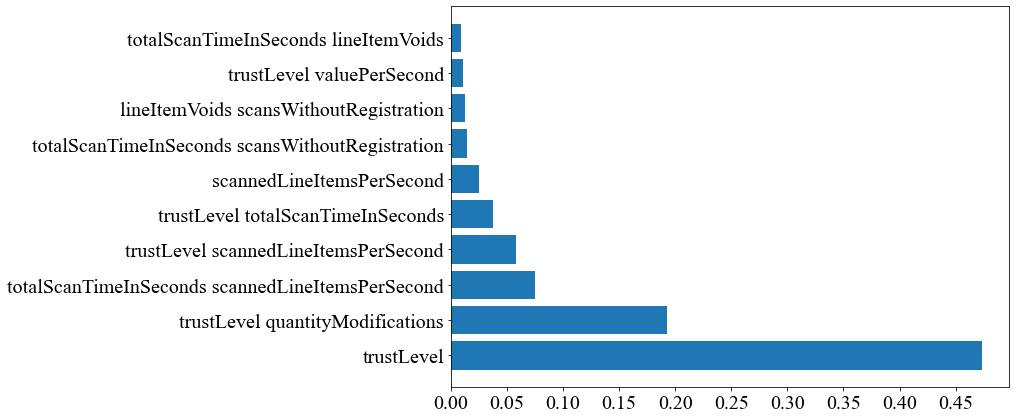

In [127]:
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 7))
plt.barh(important_features_name[:10], important_importance[:10])
plt.yticks(important_features_name[:10], fontsize=20)
plt.xticks(np.arange(0, 0.5, 0.05), fontsize=20);

## XGB with optimal parameter 0.99801

In [98]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(**best_param).fit(poly2.iloc[:, :-1], poly2.iloc[:, -1])

In [99]:
test_x = pd.read_csv('Final Project/data/mgis489_test.csv').iloc[:, 1:]
test_x.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,2,1065.0,86.40,0.0,8.0,1.0,0.025352,0.081127,0.000000
1,2,1634.0,31.61,2.0,0.0,2.0,0.001836,0.019345,0.666667
2,6,500.0,57.50,7.0,3.0,5.0,0.060000,0.115000,0.233333
3,3,711.0,50.46,10.0,3.0,1.0,0.033755,0.070970,0.416667
4,5,1213.0,30.50,8.0,9.0,1.0,0.012366,0.025144,0.533333


In [100]:
test_x.isna().mean()

trustLevel                   0.000000
totalScanTimeInSeconds       0.000000
grandTotal                   0.000088
lineItemVoids                0.000000
scansWithoutRegistration     0.000000
quantityModifications        0.000000
scannedLineItemsPerSecond    0.003224
valuePerSecond               0.009430
lineItemVoidsPerPosition     0.000000
dtype: float64

In [101]:
from sklearn.impute import KNNImputer
test_x = KNNImputer().fit_transform(test_x)

In [102]:
from sklearn.preprocessing import PolynomialFeatures
polyer = PolynomialFeatures(interaction_only=True, include_bias=False).fit(test_x)
test_x_poly = pd.DataFrame(polyer.transform(test_x), columns=polyer.get_feature_names_out().tolist())
test_x_poly.shape

(135836, 45)

In [103]:
test_prediction = xgbc.predict(test_x_poly)

In [104]:
test_x_temp = pd.read_csv('Final Project/data/mgis489_test.csv')
result = {'transactionID': test_x_temp.transactionID.values.tolist(), 'fraud': test_prediction.tolist()}

In [105]:
pd.DataFrame(result).to_csv('result_xgb_best_param.csv', index=False)

## stacking  0.99665

In [48]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict, cross_validate

rfc = RandomForestClassifier(n_jobs=-1).fit(data_poly.iloc[:, :-1], data_poly.iloc[:, -1])
mlp = MLPClassifier().fit(data_poly.iloc[:, :-1], data_poly.iloc[:, -1])
xgbc = XGBClassifier(n_jobs=-1).fit(data_poly.iloc[:, :-1], data_poly.iloc[:, -1])

rfc_prediction = rfc.predict(data_poly.iloc[:, :-1])
mlp_prediction = mlp.predict(data_poly.iloc[:, :-1])
xgbc_prediction = xgbc.predict(data_poly.iloc[:, :-1])

lg_stacking = LogisticRegression().fit(np.hstack([rfc_prediction.reshape(-1, 1), mlp_prediction.reshape(-1, 1), xgb_prediction.reshape(-1, 1)]), data_poly.iloc[:, -1])
lg_stacking_prediction = lg_stacking.predict(np.hstack([rfc_prediction.reshape(-1, 1), mlp_prediction.reshape(-1, 1), xgb_prediction.reshape(-1, 1)]))

In [49]:
test_x = pd.read_csv('Final Project/data/mgis489_test.csv').iloc[:, 1:]
test_x.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,2,1065.0,86.40,0.0,8.0,1.0,0.025352,0.081127,0.000000
1,2,1634.0,31.61,2.0,0.0,2.0,0.001836,0.019345,0.666667
2,6,500.0,57.50,7.0,3.0,5.0,0.060000,0.115000,0.233333
3,3,711.0,50.46,10.0,3.0,1.0,0.033755,0.070970,0.416667
4,5,1213.0,30.50,8.0,9.0,1.0,0.012366,0.025144,0.533333


In [50]:
test_x.isna().mean()

trustLevel                   0.000000
totalScanTimeInSeconds       0.000000
grandTotal                   0.000088
lineItemVoids                0.000000
scansWithoutRegistration     0.000000
quantityModifications        0.000000
scannedLineItemsPerSecond    0.003224
valuePerSecond               0.009430
lineItemVoidsPerPosition     0.000000
dtype: float64

In [51]:
from sklearn.impute import KNNImputer
test_x = KNNImputer().fit_transform(test_x)

In [52]:
from sklearn.preprocessing import PolynomialFeatures
polyer = PolynomialFeatures(interaction_only=True, include_bias=False).fit(test_x)
test_x_poly = pd.DataFrame(polyer.transform(test_x), columns=polyer.get_feature_names_out().tolist())
test_x_poly.shape

(135836, 45)

In [53]:
rfc_prediction = rfc.predict(test_x_poly)
mlp_prediction = mlp.predict(test_x_poly)
xgbc_prediction = xgbc.predict(test_x_poly)

In [57]:
test_prediction = lg_stacking.predict(np.hstack([rfc_prediction.reshape(-1, 1), mlp_prediction.reshape(-1, 1), xgbc_prediction.reshape(-1, 1)]))

In [58]:
test_x_temp = pd.read_csv('Final Project/data/mgis489_test.csv')
result = {'transactionID': test_x_temp.transactionID.values.tolist(), 'fraud': test_prediction.tolist()}

In [59]:
pd.DataFrame(result).to_csv('result_lgstacking_default.csv', index=False)